In [1]:
!pip install -Uq fastbook python-dotenv ipywidgets voila
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable --sys-prefix voila

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.2.10 OK


In [2]:
from fastbook import *
from fastai.vision.widgets import *
from ipywidgets import *

from dotenv import load_dotenv

/opt/conda/lib/python3.6/site-packages/fastbook/__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [3]:
load_dotenv() # loading

KEY = os.environ.get('AZURE_KEY')
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

## Attempt to create a blue eye and brown eye classifier

In [4]:
eye_types = ['blue eyes', 'brown eyes']
path = Path('eyes')

if not path.exists():
    path.mkdir()
    for img in eye_types:
        dest = path / img
        dest.mkdir(exist_ok=True)
        results = search_images_bing(KEY, f'{img} eyes')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [5]:
fns = get_image_files(path)
fns

(#266) [Path('eyes/blue eyes/00000004.JPG'),Path('eyes/blue eyes/00000000.jpg'),Path('eyes/blue eyes/00000002.jpg'),Path('eyes/blue eyes/00000010.jpg'),Path('eyes/blue eyes/00000007.jpg'),Path('eyes/blue eyes/00000009.jpg'),Path('eyes/blue eyes/00000008.jpeg'),Path('eyes/blue eyes/00000003.jpeg'),Path('eyes/blue eyes/00000013.jpg'),Path('eyes/blue eyes/00000006.jpg')...]

In [6]:
failed = verify_images(fns)
failed

(#0) []

In [7]:
failed.map(Path.unlink)

(#0) []

In [8]:
eyes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [9]:
dls = eyes.dataloaders(path)

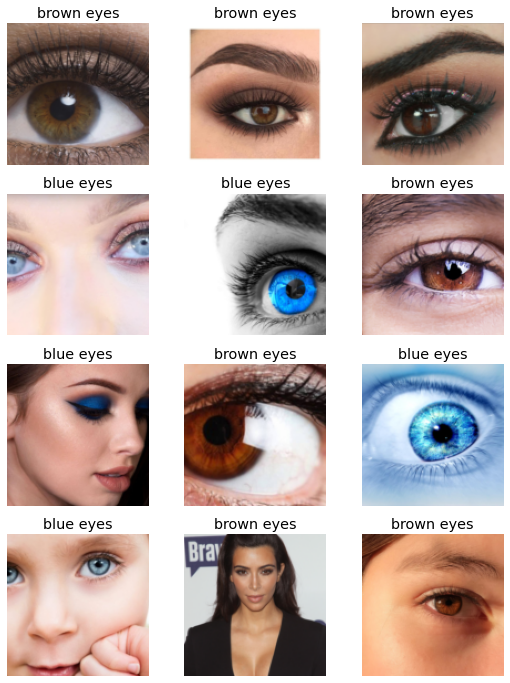

In [10]:
dls.valid.show_batch(max_n=12, nrows=4)

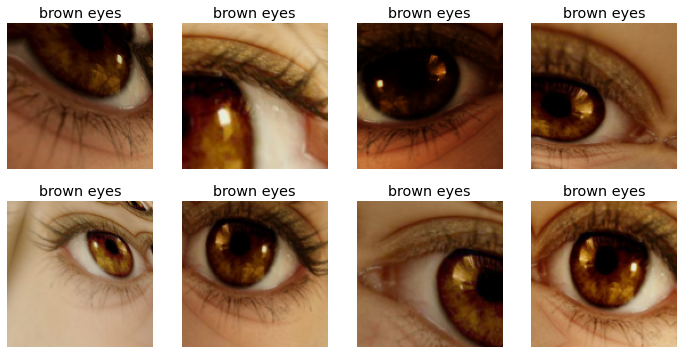

In [11]:
eyes = eyes.new(
    item_tfms=RandomResizedCrop(128),
    batch_tfms=aug_transforms(mult=2))
dls = eyes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2,
                    unique=True)

In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.131972,1.811437,0.415094,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.113571,0.906273,0.358491,00:05
1,1.070524,0.707575,0.301887,00:05
2,0.964048,0.724607,0.283019,00:05
3,0.948929,0.710011,0.226415,00:05


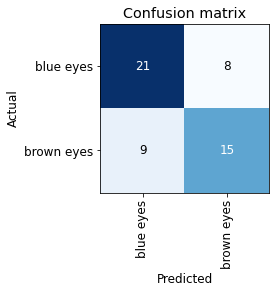

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

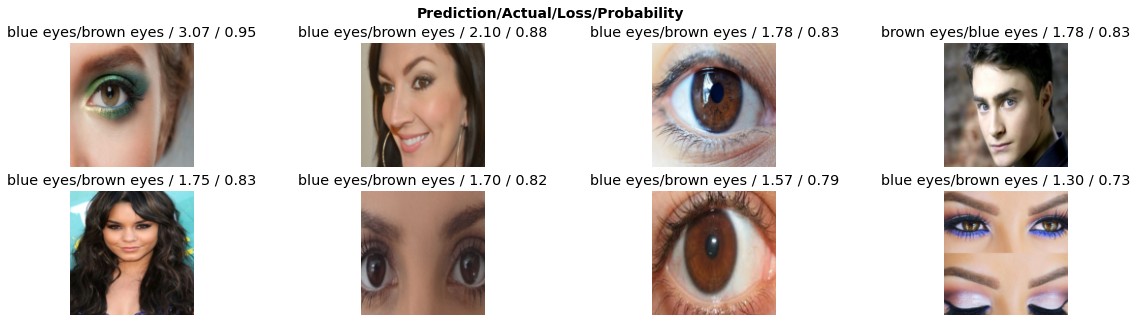

In [32]:
interp.plot_top_losses(8, nrows=2, figsize=(20,5))

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [40]:
for i in cleaner.delete():
    cleaner.fns[i].unlink()
    
for i, cat in cleaner.change():
    shutil.move(str(cleaner.fns[i]), path / cat)

In [41]:
learn.export()

In [42]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [43]:
learn_inf = load_learner(path / 'export.pkl')

In [44]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
        pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [45]:
VBox([widgets.Label('Select your eyes!'),
     btn_upload, btn_run, out_pl, lbl_pred])

IndexError: list index out of range

IndexError: list index out of range